# KNN demo

Customer churn data classification

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys

For this dataset we will look at customer churn data using a KNearestNeighbor classifier. The dataset contains multiple metrics from telecom users, like data usage, monthly revenue, used servicese, etc. This dataset is then used to classify whether a customer will churn or not.

The dataset consists of
- 7043 entries
- 23 columns (5 float, 18 int)

It is not clearly specified which columns are categorical data, as we do not have any string labels. But looking at the column names and number of unique values will give indight in how to interpret them. For example; months is encoded as an integer, but can clearly also be interpreted as an ordinal value.

(The data is already processed and normalised, but in this case the process for handling this is shown anyway)

In [2]:
df = pd.read_csv("./data/churndata_processed.csv")
round(df.describe(), 2)

,months,multiple,gb_mon,security,backup,protection,support,unlimited,contract,paperless,...,payment_Credit Card,payment_Mailed Check,internet_type_DSL,internet_type_Fiber Optic,internet_type_None,offer_Offer A,offer_Offer B,offer_Offer C,offer_Offer D,offer_Offer E
count,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,...,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00
mean,0.43,0.42,0.24,0.29,0.34,0.34,0.29,0.67,0.38,0.59,...,0.39,0.05,0.23,0.43,0.22,0.07,0.12,0.06,0.09,0.11
std,0.40,0.49,0.24,0.45,0.48,0.48,0.45,0.47,0.42,0.49,...,0.49,0.23,0.42,0.50,0.41,0.26,0.32,0.24,0.28,0.32
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.25,0.00,0.20,0.00,0.00,0.00,0.00,1.00,0.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.75,1.00,0.32,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   months                     7043 non-null   float64
 1   multiple                   7043 non-null   int64  
 2   gb_mon                     7043 non-null   float64
 3   security                   7043 non-null   int64  
 4   backup                     7043 non-null   int64  
 5   protection                 7043 non-null   int64  
 6   support                    7043 non-null   int64  
 7   unlimited                  7043 non-null   int64  
 8   contract                   7043 non-null   float64
 9   paperless                  7043 non-null   int64  
 10  monthly                    7043 non-null   float64
 11  satisfaction               7043 non-null   float64
 12  churn_value                7043 non-null   int64  
 13  payment_Credit Card        7043 non-null   int64

In [4]:
# Count unique values for each column
df_uniques = df.nunique().to_frame(name='Unique Values').rename_axis("Variable", index=0)

In [5]:
binary_variables = list(df_uniques[df_uniques['Unique Values'] == 2].index)
binary_variables

['multiple',
 'security',
 'backup',
 'protection',
 'support',
 'unlimited',
 'paperless',
 'churn_value',
 'payment_Credit Card',
 'payment_Mailed Check',
 'internet_type_DSL',
 'internet_type_Fiber Optic',
 'internet_type_None',
 'offer_Offer A',
 'offer_Offer B',
 'offer_Offer C',
 'offer_Offer D',
 'offer_Offer E']

In [6]:
categorical_variables = list(df_uniques[(6 >= df_uniques['Unique Values']) & (df_uniques['Unique Values'] > 2)].index)
# In this case, all categorical variable are ordinal variables
ordinal_variables = categorical_variables
ordinal_variables

['months', 'contract', 'satisfaction']

In [7]:
# All other variables are interpreted as numeric variables
numeric_variables = list(
    set(df.columns) - set(ordinal_variables) - set(categorical_variables) - set(binary_variables)
    )

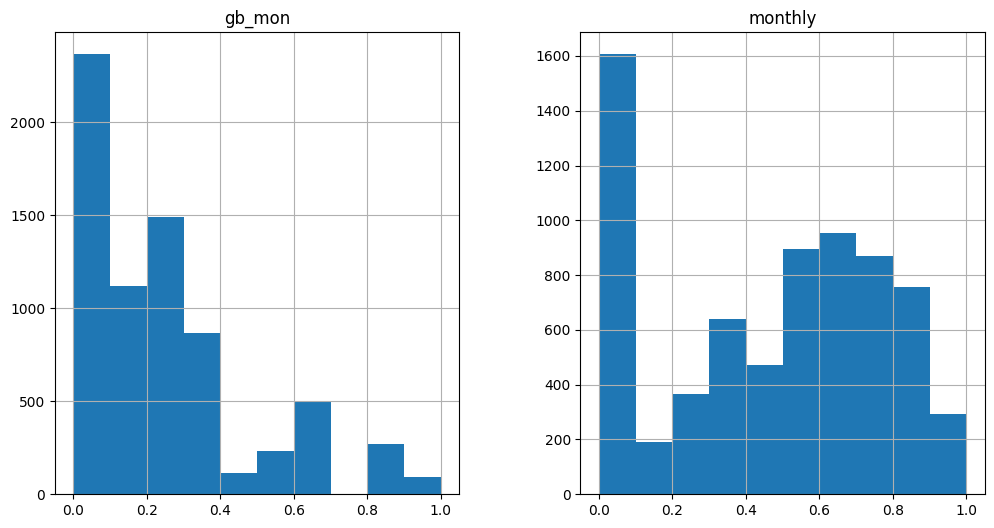

In [8]:
df[numeric_variables].hist(figsize=(12, 6));

In [9]:
# Cut months categorical into 5 equally sized bins
df['months'] = pd.cut(df['months'], bins=5)

## Preprocessing

Now we know more about the data layout, and how to interpret each variable, we can start encoding trhem into useable input features.

In [12]:
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder, MinMaxScaler

In [13]:
lb = LabelBinarizer()
le = LabelEncoder()
oc = OrdinalEncoder()
mms = MinMaxScaler()

In [15]:
# Transform all ordinal variables using the LabelEncoder
for column in ordinal_variables:
    df[column] = le.fit_transform(df[column])
    
# Transform all binary variables with LabelBinarizer
for column in binary_variables:
    df[column] = lb.fit_transform(df[column])

In [24]:
df.describe().T.rename_axis("Feature", axis=0).drop(["count", "25%", "50%", "75%"], axis=1)

,mean,std,min,max
Feature,,,,
months,1.734204,1.592924,0.0,4.0
multiple,0.421837,0.493888,0.0,1.0
gb_mon,0.241358,0.240223,0.0,1.0
security,0.286668,0.452237,0.0,1.0
backup,0.344881,0.475363,0.0,1.0
protection,0.343888,0.475038,0.0,1.0
support,0.290217,0.453895,0.0,1.0
unlimited,0.673719,0.468885,0.0,1.0
contract,0.754792,0.848468,0.0,2.0


In [29]:
for col in [ordinal_variables + numeric_variables]:
    df[col] = mms.fit_transform(df[col])

## Model selection and fitting

Now we can separate the data in train/test sets and fit a model.

Here we use K=3 and use 40% of the dataset as a test set.

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score

In [32]:
target_variable = 'churn_value'

X = df.drop(columns=[target_variable])
y = df[target_variable]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [33]:
# Estimate KNN model and report outcomes
knn = KNeighborsClassifier(n_neighbors=3)
knn = knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# Precision, recall, f-score from the multi-class support function
print(classification_report(y_test, y_pred))
print('Accuracy score: ', round(accuracy_score(y_test, y_pred), 2))
print('F1 Score: ', round(f1_score(y_test, y_pred), 2))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      2048
           1       0.77      0.72      0.74       770

    accuracy                           0.86      2818
   macro avg       0.83      0.82      0.82      2818
weighted avg       0.86      0.86      0.86      2818

Accuracy score:  0.86
F1 Score:  0.74


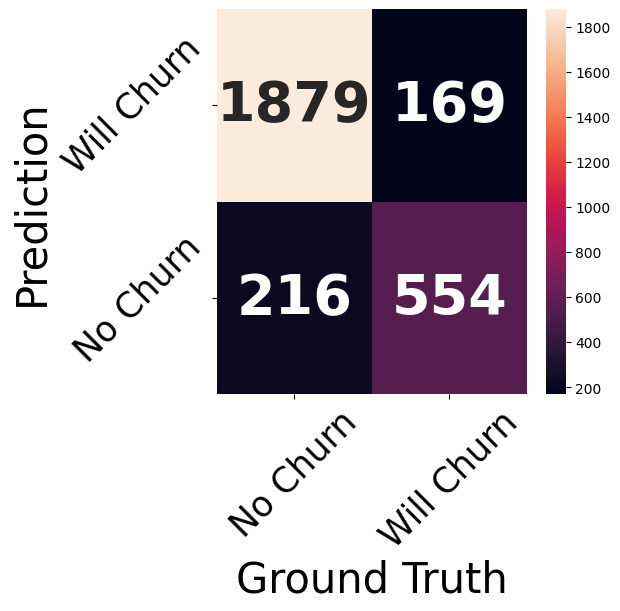

In [38]:
sns.set_palette(sns.color_palette())

_, ax = plt.subplots(figsize=(5,5))
ax = sns.heatmap(
    confusion_matrix(y_test, y_pred), 
    annot=True, 
    fmt='d', 
    annot_kws={"size": 40, "weight": "bold"})  
labels = ['No Churn', 'Will Churn']
ax.set_xticklabels(labels, fontsize=25);
ax.set_yticklabels(labels[::-1], fontsize=25);
ax.set_ylabel('Prediction', fontsize=30);
ax.set_xlabel('Ground Truth', fontsize=30);
ax.tick_params(labelrotation=45);

## Another Model

There are quite a few wrongly classified datapoints. So let's try again with a variation in hyperparameters. 

- K=5
- weigh the result by distance

In [39]:
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn = knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
# Preciision, recall, f-score from the multi-class support function
print(classification_report(y_test, y_pred))
print('Accuracy score: ', round(accuracy_score(y_test, y_pred), 2))
print('F1 Score: ', round(f1_score(y_test, y_pred), 2))

              precision    recall  f1-score   support

           0       0.91      0.92      0.91      2048
           1       0.78      0.74      0.76       770

    accuracy                           0.87      2818
   macro avg       0.84      0.83      0.84      2818
weighted avg       0.87      0.87      0.87      2818

Accuracy score:  0.87
F1 Score:  0.76


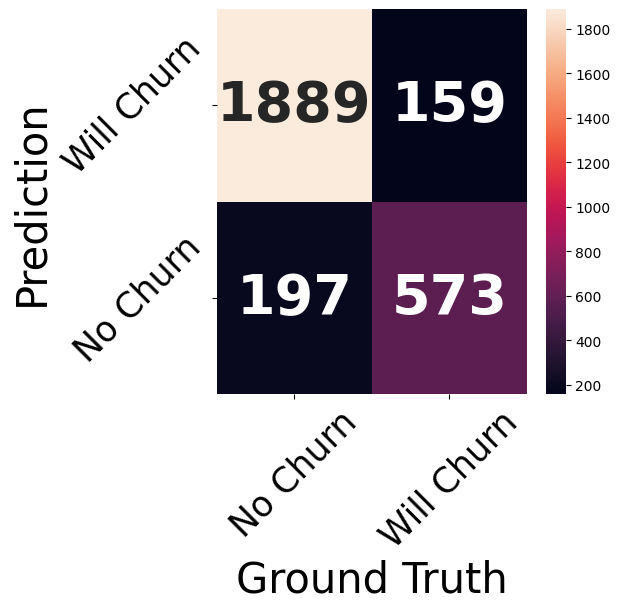

In [40]:
_, ax = plt.subplots(figsize=(5, 5))
ax = sns.heatmap(
    confusion_matrix(y_test, y_pred), 
    annot=True, 
    fmt='d', 
    annot_kws={"size": 40, "weight": "bold"})  
labels = ['No Churn', 'Will Churn']
ax.set_xticklabels(labels, fontsize=25);
ax.set_yticklabels(labels[::-1], fontsize=25);
ax.set_ylabel('Prediction', fontsize=30);
ax.set_xlabel('Ground Truth', fontsize=30);
ax.tick_params(labelrotation=45);

That is already a bit better. But we can't keep randomly trying out and hoping for better results. Let's go through the options methodically to find the optimal value for K.

## Finding the best K

In [41]:
max_k = 40
f1_scores = []
error_rates = [] # 1-accuracy

# Go through all values of k from 1 to 40
for k in range(1, max_k):
    
    # Train classifier for each ...
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    knn = knn.fit(X_train, y_train)
    
    # Calculate performance metrics
    y_pred = knn.predict(X_test)
    f1 = f1_score(y_pred, y_test)
    f1_scores.append((k, round(f1_score(y_test, y_pred), 4)))
    error = 1-round(accuracy_score(y_test, y_pred), 4)
    error_rates.append((k, error))

# Build into dataframe for evaluation
f1_results = pd.DataFrame(f1_scores, columns=['K', 'F1 Score'])
error_results = pd.DataFrame(error_rates, columns=['K', 'Error Rate'])

<Figure size 1920x1440 with 0 Axes>

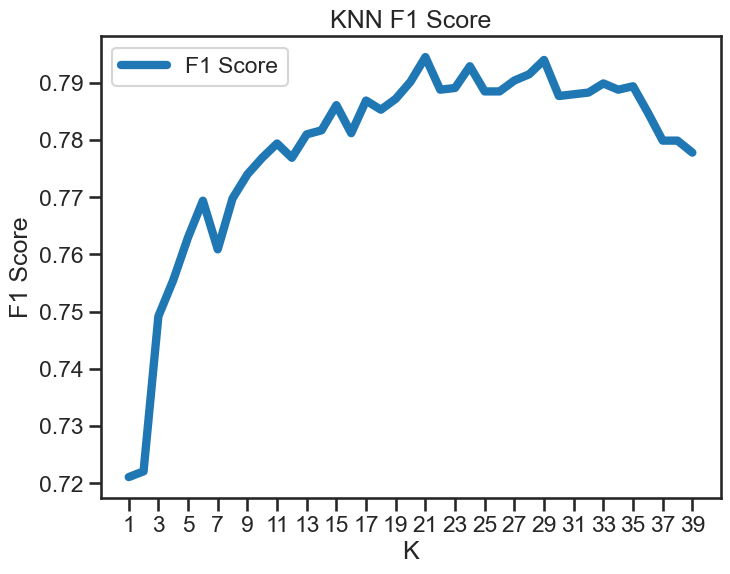

In [44]:
sns.set_context('talk')
sns.set_style('ticks')

plt.figure(dpi=300)
ax = f1_results.set_index('K').plot(figsize=(8, 6), linewidth=6)
ax.set(xlabel='K', ylabel='F1 Score')
ax.set_xticks(range(1, max_k, 2));
plt.title('KNN F1 Score');
#plt.savefig('knn_f1.png')

<Figure size 1920x1440 with 0 Axes>

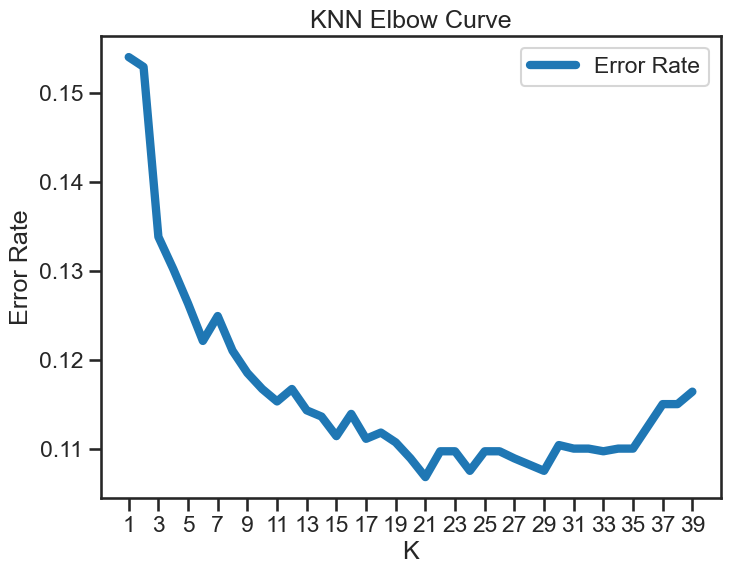

In [45]:
sns.set_context('talk')
sns.set_style('ticks')

plt.figure(dpi=300)
ax = error_results.set_index('K').plot(figsize=(8, 6), linewidth=6)
ax.set(xlabel='K', ylabel='Error Rate')
ax.set_xticks(range(1, max_k, 2))
plt.title('KNN Elbow Curve');
#plt.savefig('knn_elbow.png')

From these plots we can easily see that the best value of K lieas around K=21. Anything lower has quite a high error rate, and taking anything higher will decrease model performance and speed of classification since more calculations must be done.